In [1]:
import sys
from pathlib import Path

BASEDIR = Path("/workspaces/HARP/") / "src"  # Replace with your own basedir path for the repo

sys.path.insert(0, str(BASEDIR))

In [2]:
from __future__ import annotations

import copy
import itertools
import json
import math
import os
import pickle
import pprint
import re
import textwrap
import time
import traceback
from collections import Counter, defaultdict
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tiktoken
from IPython.display import Markdown, clear_output, display
from tqdm.auto import tqdm

import vertexai
from vertexai.batch_prediction._batch_prediction import BatchPredictionJob

In [3]:
from eval.costs import count_tokens, get_pricing
from eval.eval import run_one, create_batch, make_answer_check_dict_from_jsonl, make_results_df, accuracy_by_split
from eval.parsing_lib import *
from eval.latex_answer_check import *
from eval.response import ModelResponse
from eval.utils import read_jsonl, write_jsonl, get_uid

# Data

In [4]:
dataset = read_jsonl(BASEDIR / "data/processed/HARP.jsonl")
dataset_map = {get_uid(p): p for p in dataset}
len(dataset)

4780

# Results

In [5]:
fname = BASEDIR / "outputs/short_answer/gemini-1.5-pro-002/outputs_minerva.jsonl"

raw_responses = read_jsonl(fname)
responses = [
    {
        "uid": x["custom_id"],
        "system": x["request"]["system_instruction"],
        "prompt": x["request"]["contents"],
        "response": ModelResponse.from_response(x["response"], "google", use_batch_api=True)
    }
    for x in raw_responses
    if x["custom_id"] in dataset_map
]
raw_response_map = {x["custom_id"]: x for x in raw_responses if x["custom_id"] in dataset_map}
response_map = {o["uid"]: o for o in responses}

answer_check_dicts = make_answer_check_dict_from_jsonl(responses, dataset_map)
answer_check_results = latex_answer_check(answer_check_dicts, use_tqdm=True)
results_metadata = make_results_df(responses, answer_check_results, dataset_map, mode="shortans")

sum([x["is_correct"] for x in answer_check_results]) / len(dataset) * 100

  0%|          | 0/4780 [00:00<?, ?it/s]

Function timed out after 10 seconds
('Let the day of the week Isabella redeems her first coupon be day 0. Then she redeems her coupons on days 0, 10, 20, 30, 40, and 50. Since none of these days are Sunday, we know that none of these days are congruent to 0 modulo 7.\n\nWe are looking for a day $d$ such that $d, d+10, d+20, d+30, d+40, d+50$ are not congruent to 0 modulo 7.\nWe can reduce these modulo 7:\n$d, d+3, d+6, d+2, d+5, d+1$.\nWe want to find a day $d$ such that none of these are 0.\nIf $d=0$, then $d \\equiv 0 \\pmod{7}$.\nIf $d=1$, then $d+6 \\equiv 0 \\pmod{7}$.\nIf $d=2$, then $d+5 \\equiv 0 \\pmod{7}$.\nIf $d=3$, then $d+4 \\equiv 0 \\pmod{7}$.\nIf $d=4$, then $d+3 \\equiv 0 \\pmod{7}$.\nIf $d=5$, then $d+2 \\equiv 0 \\pmod{7}$.\nIf $d=6$, then $d+1 \\equiv 0 \\pmod{7}$.\n\nSince none of the days are Sunday, we must have $d \\equiv x \\pmod{7}$, where $x$ is not $0, 4, 1, 5, 2, 6, 3$.\nSince $d$ must be one of $0, 1, 2, 3, 4, 5, 6$, we see that there is no such $d$.\n\nHo

56.33891213389121

In [6]:
fname_zeroshot = BASEDIR / "outputs/short_answer/gemini-1.5-pro-002/outputs.jsonl"

raw_responses_zeroshot = read_jsonl(fname_zeroshot)
responses_zeroshot = [
    {
        "uid": x["custom_id"],
        "system": x["request"]["system_instruction"],
        "prompt": x["request"]["contents"],
        "response": ModelResponse.from_response(x["response"], "google", use_batch_api=True)
    }
    for x in raw_responses_zeroshot
    if x["custom_id"] in dataset_map
]
raw_response_zeroshot_map = {x["custom_id"]: x for x in raw_responses_zeroshot if x["custom_id"] in dataset_map}
response_zeroshot_map = {o["uid"]: o for o in responses_zeroshot}

answer_check_dicts_zeroshot = make_answer_check_dict_from_jsonl(responses_zeroshot, dataset_map)
answer_check_results_zeroshot = latex_answer_check(answer_check_dicts_zeroshot, use_tqdm=True)
zeroshot_results_metadata = make_results_df(responses_zeroshot, answer_check_results_zeroshot, dataset_map, mode="shortans")

sum([x["is_correct"] for x in answer_check_results_zeroshot]) / len(dataset) * 100

  0%|          | 0/4780 [00:00<?, ?it/s]

58.096234309623426

In [7]:
os.makedirs(BASEDIR / "results/gemini-1.5-pro-002", exist_ok=True)
results_metadata.to_csv(BASEDIR / "results/gemini-1.5-pro-002/results_minerva.csv")
zeroshot_results_metadata.to_csv(BASEDIR / "results/gemini-1.5-pro-002/results.csv")

In [18]:
zeroshot_results_metadata.query("uid == '2012/AMC_8/1'")

,level,subject,has_asy_problem,has_asy_solution,reason,is_correct,answer,predict,input_tokens,output_tokens
uid,,,,,,,,,,
2012/AMC_8/1,1,prealgebra,False,False,stop,True,$\hspace{.05in}9$,9,95,140


## Cost

In [18]:
PRICES = get_pricing("gemini-1.5-pro-002")
PRICES

{'input_tokens': 3.125e-07, 'output_tokens': 1.25e-06}

In [19]:
total_cost = 0
for ex in raw_responses_zeroshot:
    input_len = 0
    for part in ex["request"]["system_instruction"]["parts"]:
        input_len += count_tokens(part["text"], "gemini-1.5-pro-002")
    for content in ex["request"]["contents"]:
        for part in content["parts"]:
            input_len += count_tokens(part["text"], "gemini-1.5-pro-002")
    total_cost += PRICES["input_tokens"] * input_len

    output_len = 0
    for cand in ex["response"]["candidates"]:
        if "content" not in cand:
            continue
        for part in cand["content"]["parts"]:
            output_len += count_tokens(part["text"], "gemini-1.5-pro-002")
    total_cost += PRICES["output_tokens"] * output_len
total_cost / 2  # divide by 2 for batch api

3.4685445312500103

In [20]:
total_cost = 0
for ex in raw_responses:
    input_len = 0
    for part in ex["request"]["system_instruction"]["parts"]:
        input_len += count_tokens(part["text"], "gemini-1.5-pro-002")
    for content in ex["request"]["contents"]:
        for part in content["parts"]:
            input_len += count_tokens(part["text"], "gemini-1.5-pro-002")
    total_cost += PRICES["input_tokens"] * input_len

    output_len = 0
    for cand in ex["response"]["candidates"]:
        if "content" not in cand:
            continue
        for part in cand["content"]["parts"]:
            output_len += count_tokens(part["text"], "gemini-1.5-pro-002")
    total_cost += PRICES["output_tokens"] * output_len
total_cost / 2  # divide by 2 for batch api

3.970216406249982

## Finish reason

- 1 problem was stopped for "copyright". Seems like the question was copied into a book of math problems?
    - 2001/AMC_12/16
- For the 13 max_length hits
    - almost always, it seems to start repeating a string of tokens
    - One exception is `2016/AIME_I/12`, where is tests all possible values starting from 1. It starts listing a number of possible decompositions of a number as kp+r in increasing order, which I'm not sure is useful, which is kinda like repetition.

In [18]:
results_metadata.value_counts("reason")

reason
stop         4780
length         13
copyright       1
Name: count, dtype: int64

In [83]:
results_metadata.query("reason != 'stop'").value_counts(["level", "reason"]).sort_index()

level  reason   
1      length       4
3      copyright    1
       length       5
5      length       2
6      length       2
Name: count, dtype: int64

In [84]:
results_metadata.query("reason != 'stop'").value_counts(["subject", "reason"]).sort_index()

subject                   reason   
algebra                   length       2
counting_and_probability  copyright    1
geometry                  length       4
number_theory             length       6
prealgebra                length       1
Name: count, dtype: int64

In [61]:
results_metadata.query("reason != 'stop'")

,level,subject,reason,is_correct
uid,,,,
2003/AMC_8/14,1,number_theory,length,False
2004/AIME_II/14,6,number_theory,length,False
1995/AIME/4,3,geometry,length,False
1991/AJHSME/20,1,number_theory,length,False
2002/AIME_I/4,3,algebra,length,False
2002/AMC_8/16,1,geometry,length,False
1968/AHSME/18,3,geometry,length,False
2004/AIME_I/15,6,number_theory,length,False
2005/AMC_12B/15,3,prealgebra,length,False


In [48]:
raw_response_map["2001/AMC_12/16"]["request"]["contents"][-2]

{'parts': [{'text': 'Problem:\nA spider has one sock and one shoe for each of its eight legs. In how many different orders can the spider put on its socks and shoes, assuming that, on each leg, the sock must be put on before the shoe?'}],
 'role': 'user'}

In [47]:
raw_response_map["2001/AMC_12/16"]["response"]

{'candidates': [{'avgLogprobs': 'NaN',
   'citationMetadata': {'citations': [{'endIndex': 846,
      'startIndex': 703,
      'uri': 'https://www.coursehero.com/textbook-solutions/College-Algebra-6th-Edition-9780321916600-1478/Chapter-8-Problem-65-2514052/'}]},
   'finishReason': 'RECITATION'}],
 'modelVersion': 'gemini-1.5-pro-002@default',
 'usageMetadata': {'promptTokenCount': 753, 'totalTokenCount': 753}}

In [20]:
zeroshot_results_metadata.query("reason != 'stop'")

,level,subject,reason,is_correct
uid,,,,
2020/AIME_II/12,5,number_theory,length,False
2002/AMC_12A/20,3,number_theory,length,False
1998/AIME/10,5,geometry,copyright,False
1987/AHSME/29,4,algebra,length,False
1997/AIME/14,6,precalculus,copyright,False
2006/AIME_I/3,3,number_theory,length,False
2024/AIME_II/14,6,number_theory,length,False
2016/AMC_12B/22,4,number_theory,length,False
1983/AIME/15,6,precalculus,length,False


In [30]:
display(Markdown(response_zeroshot_map[ex_uid]["prompt"][-2]["parts"][0]["text"]))

Problem:
A regular hexagon with center at the origin in the complex plane has opposite pairs of sides one unit apart. One pair of sides is parallel to the imaginary axis. Let $R$ be the region outside the hexagon, and let $S = \left\lbrace\frac{1}{z}|z \in R\right\rbrace$. Then the area of $S$ has the form $a\pi + \sqrt{b}$, where $a$ and $b$ are positive integers. Find $a + b$.

In [25]:
ex_uid = "2008/AIME_II/13"
display(Markdown(response_zeroshot_map[ex_uid]["response"].completions[0].completion))

Let the vertices of the regular hexagon be $v_1, v_2, \dots, v_6$. Since the hexagon is centered at the origin, the vertices are given by $v_k = re^{i(2k-1)\pi/6}$ for $k = 1, 2, \dots, 6$, where $r$ is the distance from the origin to each vertex.
The distance between opposite vertices is $2r$. The distance between opposite sides is given as 1. The distance between opposite sides is given by $r\sqrt{3}$. Thus, $r\sqrt{3} = 1$, so $r = \frac{1}{\sqrt{3}}$.
The vertices are $v_k = \frac{1}{\sqrt{3}}e^{i(2k-1)\pi/6}$ for $k = 1, 2, \dots, 6$.
The region $R$ is the exterior of the hexagon. The set $S$ is the image of $R$ under the transformation $w = \frac{1}{z}$.
The transformation $w = \frac{1}{z}$ maps the exterior of the hexagon to the interior of another hexagon.
Let $w_k = \frac{1}{v_k} = \frac{1}{\frac{1}{\sqrt{3}}e^{i(2k-1)\pi/6}} = \sqrt{3}e^{-i(2k-1)\pi/6}$ for $k = 1, 2, \dots, 6$.
The new hexagon has vertices $w_k = \sqrt{3}e^{-i(2k-1)\pi/6}$ for $k = 1, 2, \dots, 6$.
The distance from the origin to each vertex is $\sqrt{3}$. The side length of the new hexagon is $\sqrt{3} \cdot 2 \sin(\pi/6) = \sqrt{3}$.
The area of the new hexagon is $6 \cdot \frac{(\sqrt{3})^2 \sqrt{3}}{4} = \frac{9\sqrt{3}}{2}$.
The area of $S$ is the area of the hexagon with vertices $w_k$, which is $\frac{9\sqrt{3}}{2}$.
The area of $S$ is of the form $a\pi + \sqrt{b}$. In this case, $a = 0$ and $b = \frac{81 \cdot 3}{4} = \frac{243}{4}$.
However, $a$ and $b$ must be integers.
The area of $S$ is $\frac{9\sqrt{3}}{2}$.
We are given that the area of $S$ is $a\pi + \sqrt{b}$.
Thus, $a=0$ and $\sqrt{b} = \frac{9\sqrt{3}}{2}$, so $b = \frac{81 \cdot 3}{4} = \frac{243}{4}$.
Since $a$ and $b$ are integers, we have $a=0$ and $b = \frac{243}{4}$.
The area of $S$ is $0\pi + \frac{9\sqrt{3}}{2}$, so $a=0$ and $b = \frac{243}{4}$.
The area of $S$ is $\frac{9\sqrt{3}}{2} = 0\pi + \sqrt{\frac{243}{4}}$.
Then $a=0$ and $b = \frac{243}{4}$.
The area of $S$ is $\frac{9\sqrt{3}}{2}$, so $a=0$ and $\sqrt{b} = \frac{9\sqrt{3}}{2}$, so $b = \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 + \frac{243}{4}$.
$a+b = 0 +

In [31]:
dataset_map["2009/AMC_12A/25"]["url"]

'https://artofproblemsolving.com/wiki/index.php/2009_AMC_12A_Problems/Problem_25'

In [32]:
raw_response_zeroshot_map["2009/AMC_12A/25"]["response"]

{'candidates': [{'avgLogprobs': 'NaN',
   'citationMetadata': {'citations': [{'endIndex': 1748,
      'startIndex': 1571,
      'title': 'A Graphical Approach to College Algebra and Trigonometry'}]},
   'finishReason': 'RECITATION'}],
 'modelVersion': 'gemini-1.5-pro-002@default',
 'usageMetadata': {'promptTokenCount': 141, 'totalTokenCount': 141}}

## Accuracy

In [9]:
accuracy_by_split(results_metadata, "level")

,count,accuracy
level,,
1,799,69.086358
2,1505,58.604651
3,1363,41.012472
4,719,22.114047
5,197,11.675127
6,197,5.076142


In [10]:
accuracy_by_split(results_metadata, "subject")

,count,accuracy
subject,,
algebra,970,51.237113
counting_and_probability,812,43.226601
geometry,1268,30.047319
number_theory,601,45.257903
prealgebra,889,69.403825
precalculus,240,27.916667


In [27]:
results_metadata[
    results_metadata.index.str.startswith("2024/AIME")
].value_counts("is_correct")

is_correct
False    27
True      3
Name: count, dtype: int64

In [9]:
accuracy_by_split(zeroshot_results_metadata, "level")

,count,accuracy
level,,
1,799,69.086358
2,1505,58.604651
3,1363,41.012472
4,719,22.114047
5,197,11.675127
6,197,5.076142


In [10]:
accuracy_by_split(zeroshot_results_metadata, "subject")

,count,accuracy
subject,,
algebra,970,51.237113
counting_and_probability,812,43.226601
geometry,1268,30.047319
number_theory,601,45.257903
prealgebra,889,69.403825
precalculus,240,27.916667


In [19]:
zeroshot_results_metadata[
    zeroshot_results_metadata.index.str.startswith("2024/AIME")
].value_counts("is_correct")

is_correct
False    25
True      5
Name: count, dtype: int64

## Has asy

In [21]:
zeroshot_results_metadata.value_counts("has_asy_problem")

has_asy_problem
False    4161
True      626
Name: count, dtype: int64

In [24]:
zeroshot_results_metadata.value_counts(["has_asy_problem", "level"]).sort_index()

has_asy_problem  level
False            1         607
                 2        1302
                 3        1234
                 4         649
                 5         185
                 6         184
True             1         192
                 2         204
                 3         132
                 4          73
                 5          12
                 6          13
Name: count, dtype: int64

In [25]:
zeroshot_results_metadata.value_counts(["has_asy_problem", "subject"]).sort_index()

has_asy_problem  subject                 
False            algebra                     951
                 calculus                      4
                 counting_and_probability    724
                 geometry                    834
                 number_theory               593
                 prealgebra                  827
                 precalculus                 228
True             algebra                      20
                 calculus                      1
                 counting_and_probability     88
                 geometry                    434
                 number_theory                 9
                 prealgebra                   62
                 precalculus                  12
Name: count, dtype: int64

In [22]:
zeroshot_results_metadata.value_counts("has_asy_solution")

has_asy_solution
False    4248
True      539
Name: count, dtype: int64

In [27]:
zeroshot_results_metadata.groupby("has_asy_problem")["is_correct"].sum() / zeroshot_results_metadata.groupby("has_asy_problem")["is_correct"].count()

has_asy_problem
False    0.603701
True     0.402556
Name: is_correct, dtype: float64

In [28]:
zeroshot_results_metadata.groupby(["has_asy_problem", "level"])["is_correct"].sum() / zeroshot_results_metadata.groupby(["has_asy_problem", "level"])["is_correct"].count()

has_asy_problem  level
False            1        0.831960
                 2        0.745008
                 3        0.589951
                 4        0.391371
                 5        0.194595
                 6        0.103261
True             1        0.520833
                 2        0.436275
                 3        0.333333
                 4        0.232877
                 5        0.166667
                 6        0.000000
Name: is_correct, dtype: float64

## Output lengths

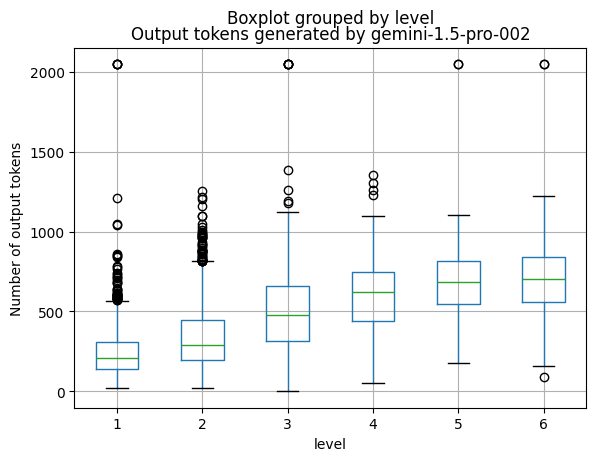

In [28]:
results_metadata.boxplot("output_tokens", "level")
plt.title("Output tokens generated by gemini-1.5-pro-002")
plt.ylabel("Number of output tokens")
plt.show()

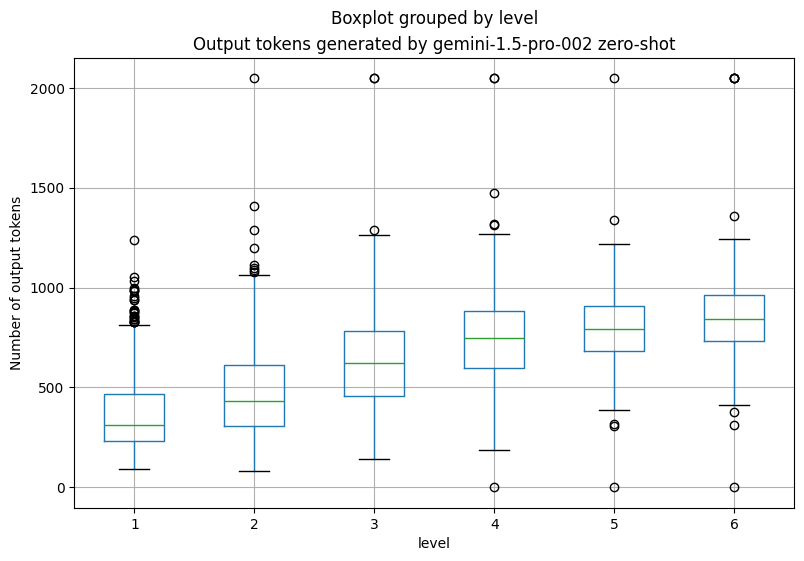

In [29]:
plt.figure(figsize=(9,6))
zeroshot_results_metadata.boxplot("output_tokens", "level", ax=plt.gca())
plt.title("Output tokens generated by gemini-1.5-pro-002 zero-shot")
plt.ylabel("Number of output tokens")
plt.show()

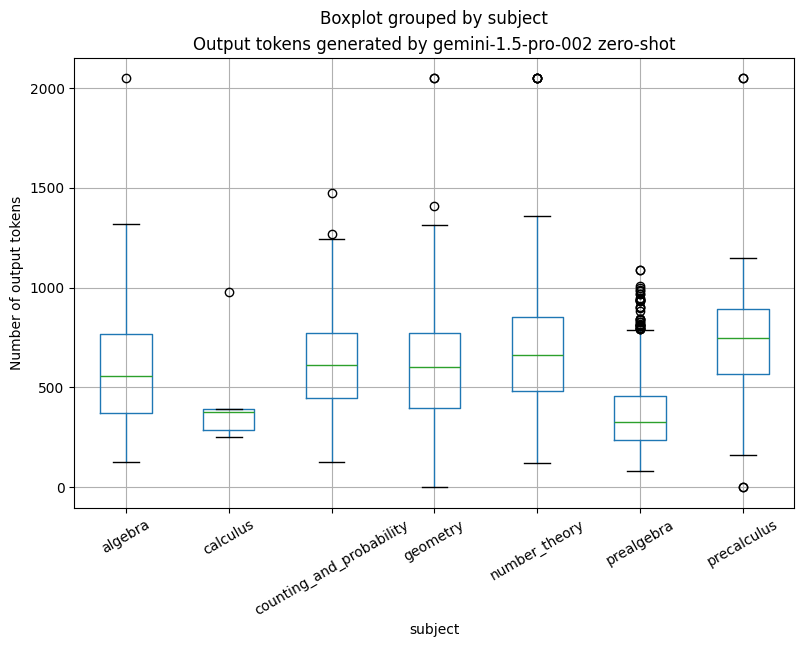

In [30]:
plt.figure(figsize=(9,6))
zeroshot_results_metadata.boxplot("output_tokens", "subject", ax=plt.gca())
plt.title("Output tokens generated by gemini-1.5-pro-002 zero-shot")
plt.ylabel("Number of output tokens")
plt.xticks(rotation=30)
plt.show()

In [31]:
zeroshot_results_metadata.query("output_tokens == 0")

,level,subject,reason,is_correct,answer,predict,input_tokens,output_tokens
uid,,,,,,,,
1998/AIME/10,5,geometry,copyright,False,$152$,None,167,0
1997/AIME/14,6,precalculus,copyright,False,$582$,None,139,0
2009/AMC_12A/25,4,precalculus,copyright,False,$0$,None,141,0


## Look at some random outputs

In [36]:
wrong_answers = [
    {
        "uid": answer_check_dicts[i]["uid"],
        "url": dataset_map[answer_check_dicts[i]["uid"]]["url"],
        "level": dataset_map[answer_check_dicts[i]["uid"]]["level"],
        "subject": dataset_map[answer_check_dicts[i]["uid"]]["subject"],
        "problem": answer_check_dicts[i]["problem"],
        **x
    } 
    for i, x in enumerate(answer_check_results) 
    if not x["is_correct"] and responses[i]["response"].completions[0].finish_reason == "stop"
]

In [37]:
len(wrong_answers)

2101

In [130]:
rand_idx = np.random.randint(len(wrong_answers))
wrong_answers[rand_idx]

{'uid': '2021_Fall/AMC_10B/10',
 'url': 'https://artofproblemsolving.com/wiki/index.php/2021_Fall_AMC_10B_Problems/Problem_10',
 'level': 2,
 'subject': 'number_theory',
 'problem': 'Forty slips of paper numbered $1$ to $40$ are placed in a hat. Alice and Bob each draw one number from the hat without replacement, keeping their numbers hidden from each other. Alice says, "I can\'t tell who has the larger number." Then Bob says, "I know who has the larger number." Alice says, "You do? Is your number prime?" Bob replies, "Yes." Alice says, "In that case, if I multiply your number by $100$ and add my number, the result is a perfect square. " What is the sum of the two numbers drawn from the hat?',
 'generated_text': 'Let $A$ be Alice\'s number and $B$ be Bob\'s number.\nAlice\'s statement "I can\'t tell who has the larger number" means $A \\neq 1$ and $A \\neq 40$. So $2 \\le A \\le 39$.\nBob\'s statement "I know who has the larger number" means $B$ is such that for any $A$ with $2 \\le A 

In [115]:
wrong_answers[1142]

{'uid': '1972/AHSME/1',
 'url': 'https://artofproblemsolving.com/wiki/index.php/1972_AHSME_Problems/Problem_1',
 'problem': 'The lengths in inches of the three sides of each of four triangles $I, II, III$, and $IV$ are as follows: $\\begin{array}{rlrl} \\hbox{I}& 3,\\ 4,\\ \\hbox{and}\\ 5\\qquad & \\hbox{III}& 7,\\ 24,\\ \\hbox{and}\\ 25\\\\ \\hbox{II}& 4,\\ 7\\frac{1}{2},\\ \\hbox{and}\\ 8\\frac{1}{2}\\qquad & \\hbox{IV}& 3\\frac{1}{2},\\ 4\\frac{1}{2},\\ \\hbox{and}\\ 5\\frac{1}{2}.\\end{array}$ Of these four given triangles, the only right triangles are',
 'generated_text': 'We check if the Pythagorean theorem holds for each triangle.\n\nI. $3^2 + 4^2 = 9 + 16 = 25 = 5^2$. This is a right triangle.\n\nII. $4^2 + (7.5)^2 = 16 + 56.25 = 72.25$. $(8.5)^2 = 72.25$. This is a right triangle.\n\nIII. $7^2 + 24^2 = 49 + 576 = 625 = 25^2$. This is a right triangle.\n\nIV. $(3.5)^2 + (4.5)^2 = 12.25 + 20.25 = 32.5$. $(5.5)^2 = 30.25$. This is not a right triangle.\n\nThe right triangles are 

## Zero-shot vs Minerva

In [32]:
results_metadata.value_counts("is_correct")

is_correct
True     2680
False    2107
Name: count, dtype: int64

In [33]:
zeroshot_results_metadata.value_counts("is_correct")

is_correct
True     2764
False    2023
Name: count, dtype: int64

In [38]:
acr_map = {acr["uid"]: acr for acr in answer_check_results}
acr_zs_map = {acr["uid"]: acr for acr in answer_check_results_zeroshot}

In [25]:
df = (
    pd.concat([
        results_metadata.assign(prompt_type="minerva").set_index(["level", "subject", "answer"], append=True),
        zeroshot_results_metadata.assign(prompt_type="zeroshot").set_index(["level", "subject", "answer"], append=True),
    ])
    .set_index("prompt_type", append=True)
    .unstack("prompt_type")
    .reset_index()
    .set_index("uid")
    .sort_index()
)
df.head()

level     subject                answer  reason           \
prompt_type                                           minerva zeroshot   
uid                                                                      
1950/AHSME/1      2  prealgebra       $10\frac{2}{3}$    stop     stop   
1950/AHSME/10     2  prealgebra            $3+\sqrt6$    stop     stop   
1950/AHSME/13     2     algebra  $0,1,2\text{ and }4$    stop     stop   
1950/AHSME/16     2     algebra                   $5$    stop     stop   
1950/AHSME/17     2     algebra     $y=100-5x-5x^{2}$    stop     stop   

              is_correct                        predict                        \
prompt_type      minerva zeroshot               minerva              zeroshot   
uid                                                                             
1950/AHSME/1        True     True          \frac{32}{3}          \frac{32}{3}   
1950/AHSME/10       True     True            3+\sqrt{6}            3+\sqrt{6}   
1950/AHSME/13      False    False            0, 1, 2, 4    \boxed{0, 1, 2, 4}   
1950/AHSME/16       True    False                     5             \boxed{3}   
1950/AHSME/17       True     True  y = -5x^2 - 5x + 100  y = -5x^2 - 5x + 100   

              input_tokens          output_tokens           
prompt_type        minerva zeroshot       minerva zeroshot  
uid                                                         
1950/AHSME/1           733       85           128      139  
1950/AHSME/10          734       86           219      312  
1950/AHSME/13          729       81           134      238  
1950/AHSME/16          737       89           124      247  
1950/AHSME/17          786      138           402      637

<Axes: ylabel='Frequency'>

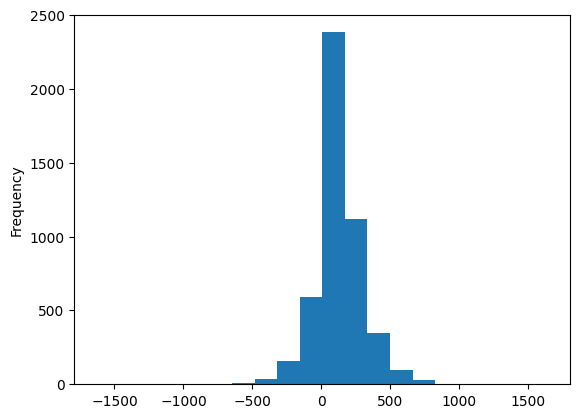

In [101]:
(df[("output_tokens", "zeroshot")] - df[("output_tokens", "minerva")]).plot.hist(bins=20)

<Axes: ylabel='Frequency'>

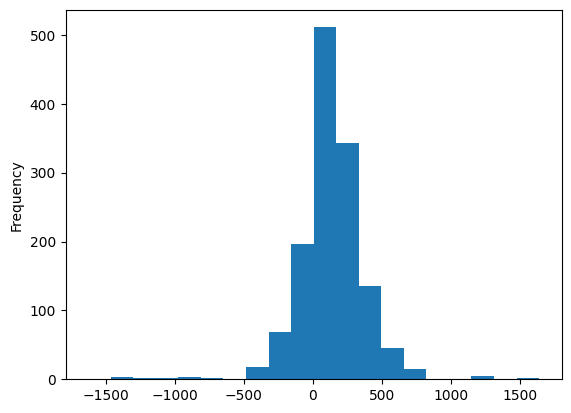

In [102]:
(df[
    ~df[("is_correct", "zeroshot")]
    & ~df[("is_correct", "minerva")]
    & (df[("predict", "zeroshot")] != df[("predict", "minerva")])
][("output_tokens", "zeroshot")] - df[
    ~df[("is_correct", "zeroshot")]
    & ~df[("is_correct", "minerva")]
    & (df[("predict", "zeroshot")] != df[("predict", "minerva")])
][("output_tokens", "minerva")]).plot.hist(bins=20)

In [97]:
df[
    ~df[("is_correct", "zeroshot")]
    & ~df[("is_correct", "minerva")]
    & (df[("predict", "zeroshot")] != df[("predict", "minerva")])
][["answer", "is_correct", "predict", "output_tokens"]]

answer is_correct           \
prompt_type                                    minerva zeroshot   
uid                                                               
1950/AHSME/13          $0,1,2\text{ and }4$      False    False   
1950/AHSME/21            $24\text{ in}^{3}$      False    False   
1950/AHSME/27               $34\text{ mph}$      False    False   
1950/AHSME/3         $\text{None of these}$      False    False   
1950/AHSME/39  $\text{Only }4\text{ and }5$      False    False   
...                                     ...        ...      ...   
2024/AMC_8/16                          $11$      False    False   
2024/AMC_8/24                           $5$      False    False   
2024/AMC_8/25               $\frac{20}{33}$      False    False   
2024/AMC_8/7                            $5$      False    False   
2024/AMC_8/9                           $28$      False    False   

                       predict                     output_tokens           
prompt_type            minerva            zeroshot       minerva zeroshot  
uid                                                                        
1950/AHSME/13       0, 1, 2, 4  \boxed{0, 1, 2, 4}           134      238  
1950/AHSME/21               24          \boxed{24}           151      250  
1950/AHSME/27    \frac{240}{7}                34.3           304      207  
1950/AHSME/3                 2           \boxed{2}           160      224  
1950/AHSME/39    (3), (4), (5)   (3), (4), and (5)           351      449  
...                        ...                 ...           ...      ...  
2024/AMC_8/16                9                   6           582      719  
2024/AMC_8/24            12.33           \sqrt{79}           742      397  
2024/AMC_8/25    \frac{22}{55}         \frac{2}{3}           818      840  
2024/AMC_8/7                 3                   1           430      810  
2024/AMC_8/9   a multiple of 7                   7           236      314  

[1356 rows x 7 columns]

In [49]:
acr_map["2023/AMC_12B/9"]

{'uid': '2023/AMC_12B/9',
 'problem': 'What is the area of the region in the coordinate plane defined by $| | x | - 1 | + | | y | - 1 | \\le 1$?',
 'finish_reason': <FinishReason.STOP: 'stop'>,
 'generated_text': 'We consider the four cases for the signs of $|x|-1$ and $|y|-1$.\n\nCase 1: $|x|-1 \\ge 0$ and $|y|-1 \\ge 0$. Then $|x| \\ge 1$ and $|y| \\ge 1$, so $(|x|-1) + (|y|-1) \\le 1$, which means $|x| + |y| \\le 3$.\nCase 2: $|x|-1 \\ge 0$ and $|y|-1 < 0$. Then $|x| \\ge 1$ and $|y| < 1$, so $(|x|-1) - (|y|-1) \\le 1$, which means $|x| - |y| \\le 1$.\nCase 3: $|x|-1 < 0$ and $|y|-1 \\ge 0$. Then $|x| < 1$ and $|y| \\ge 1$, so $-(|x|-1) + (|y|-1) \\le 1$, which means $-|x| + |y| \\le 1$.\nCase 4: $|x|-1 < 0$ and $|y|-1 < 0$. Then $|x| < 1$ and $|y| < 1$, so $-(|x|-1) - (|y|-1) \\le 1$, which means $-|x| - |y| \\le -1$, or $|x| + |y| \\ge 1$.\n\nThe region is a square with vertices $(1,2)$, $(2,1)$, $(-1,2)$, $(-2,1)$, $(1,-2)$, $(2,-1)$, $(-1,-2)$, $(-2,-1)$. The side length of the 

In [48]:
acr_zs_map["2023/AMC_12B/9"]

{'uid': '2023/AMC_12B/9',
 'problem': 'What is the area of the region in the coordinate plane defined by $| | x | - 1 | + | | y | - 1 | \\le 1$?',
 'finish_reason': <FinishReason.STOP: 'stop'>,
 'generated_text': 'We can divide the $xy$-plane into regions based on the signs of $|x|-1$ and $|y|-1$.\n\nCase 1: $|x| - 1 \\ge 0$ and $|y| - 1 \\ge 0$. This means $|x| \\ge 1$ and $|y| \\ge 1$.\nThen the inequality becomes $(|x| - 1) + (|y| - 1) \\le 1$, or $|x| + |y| \\le 3$.\nSince $|x| \\ge 1$ and $|y| \\ge 1$, we have four regions in the plane.\nIn the first quadrant, we have $x+y \\le 3$, $x \\ge 1$, $y \\ge 1$. This is a triangle with vertices $(1,2)$, $(2,1)$, and $(1,1)$. The area is $\\frac{1}{2} \\cdot 1 \\cdot 1 = \\frac{1}{2}$.\nSince there are four such triangles, the total area is $4 \\cdot \\frac{1}{2} = 2$.\n\nCase 2: $|x| - 1 \\ge 0$ and $|y| - 1 < 0$. This means $|x| \\ge 1$ and $|y| < 1$.\nThen the inequality becomes $(|x| - 1) - (|y| - 1) \\le 1$, or $|x| - |y| \\le 1$.\nI

- 1994/AIME/13: had right answer but went to do and return smth else
- 2020/AMC_12B/16: just incorrect math
- 1984/AIME/3: incorrect, random factor of 1/2 bc triangle area
- 2005/AMC_12B/22: minerva jumps to the answer quicker (writes out fewer steps), and maybe does smth wrong in between?
- 2022/AMC_8/15: inspected graph incorrectly. Also uses fewer tokens
- 1965/AHSME/36: used cos instead of sin?
- 1993/AHSME/10: wrong interp of the problem

In [93]:
rand_uid = np.random.choice(df[
    df[("is_correct", "zeroshot")]
    & ~df[("is_correct", "minerva")]
    & (df[("predict", "zeroshot")] != df[("predict", "minerva")])
].index)
rand_uid

'2000/AIME_II/6'

In [94]:
display(Markdown(acr_map[rand_uid]["problem"]))

One base of a trapezoid is $100$ units longer than the other base. The segment that joins the midpoints of the legs divides the trapezoid into two regions whose areas are in the ratio $2: 3$. Let $x$ be the length of the segment joining the legs of the trapezoid that is parallel to the bases and that divides the trapezoid into two regions of equal area. Find the greatest integer that does not exceed $x^2/100$.

In [95]:
display(Markdown(acr_map[rand_uid]["generated_text"].replace("\n", "\n\n")))

Let the lengths of the two bases be $b$ and $b+100$. Let the height of the trapezoid be $h$. The median of the trapezoid has length $\frac{b+(b+100)}{2} = b+50$. The segment joining the midpoints of the legs has length $b+50$.

Let $h_1$ and $h_2$ be the heights of the two trapezoids formed by the segment joining the midpoints of the legs. Then $h_1+h_2=h$. The area of the trapezoid is $\frac{h}{2}(b+b+100) = h(b+50)$. The areas of the two smaller trapezoids are $\frac{h_1}{2}(b+b+50) = \frac{h_1}{2}(2b+50)$ and $\frac{h_2}{2}(b+50+b+100) = \frac{h_2}{2}(2b+150)$.

We are given that the ratio of the areas is $2:3$, so

$$\frac{\frac{h_1}{2}(2b+50)}{\frac{h_2}{2}(2b+150)} = \frac{2}{3}.$$

$$\frac{h_1(2b+50)}{h_2(2b+150)} = \frac{2}{3}.$$

Since the segment joining the midpoints of the legs has length $b+50$, we have

$$\frac{h_1}{h_2} = \frac{b+25}{b+75}.$$

So

$$\frac{(b+25)(2b+50)}{(b+75)(2b+150)} = \frac{2}{3}.$$

$$3(2b^2+100b+1250) = 2(2b^2+300b+11250).$$

$$6b^2+300b+3750 = 4b^2+600b+22500.$$

$$2b^2-300b-18750=0.$$

$$b^2-150b-9375=0.$$

$$b = \frac{150\pm\sqrt{150^2-4(-9375)}}{2} = \frac{150\pm\sqrt{22500+37500}}{2} = \frac{150\pm\sqrt{60000}}{2} = \frac{150\pm 150\sqrt{4\cdot\frac{100}{4}}}{2} = 75\pm 75\sqrt{4} = 75\pm 150.$$

Since $b>0$, $b=225$.

The area of the trapezoid is $h(b+50) = 275h$. We want to find $x$ such that the area of the trapezoid with bases $b$ and $x$ is $137.5h$.

$\frac{h}{2}(b+x) = 137.5h$, so $225+x = 275$, so $x=150$.

$x^2/100 = 150^2/100 = 22500/100 = 225$.



Final Answer: The final answer is $225$. 

In [96]:
display(Markdown(acr_zs_map[rand_uid]["generated_text"].replace("\n", "\n\n")))

Let the lengths of the two bases of the trapezoid be $a$ and $b$, with $a < b$. We are given that $b = a + 100$.

Let $m$ be the length of the midsegment, which is the segment joining the midpoints of the legs. We know that $m = \frac{a+b}{2} = \frac{a + a + 100}{2} = a + 50$.

The midsegment divides the trapezoid into two smaller trapezoids. Let the areas of these two trapezoids be $A_1$ and $A_2$, with $A_1$ being the area of the trapezoid adjacent to the base with length $a$.

We are given that $\frac{A_1}{A_2} = \frac{2}{3}$.

The height of the trapezoid adjacent to base $a$ is half the height of the original trapezoid, and the height of the trapezoid adjacent to base $b$ is also half the height of the original trapezoid. Let $h$ be the height of the original trapezoid. Then the height of each smaller trapezoid is $h/2$.

$A_1 = \frac{1}{2} \cdot \frac{h}{2} (a + m) = \frac{h}{4}(a + a + 50) = \frac{h}{4}(2a + 50)$

$A_2 = \frac{1}{2} \cdot \frac{h}{2} (m + b) = \frac{h}{4}(a + 50 + a + 100) = \frac{h}{4}(2a + 150)$

We have $\frac{A_1}{A_2} = \frac{2a + 50}{2a + 150} = \frac{2}{3}$.

Cross-multiplying, we get $3(2a + 50) = 2(2a + 150)$, which simplifies to $6a + 150 = 4a + 300$.

Then $2a = 150$, so $a = 75$.

Thus, $b = a + 100 = 75 + 100 = 175$.

The area of the trapezoid is $A = \frac{1}{2} (a+b)h = \frac{1}{2} (75+175)h = 125h$.

Let $x$ be the length of the segment parallel to the bases that divides the trapezoid into two regions of equal area.

The area of the trapezoid is $A = 125h$. We want to find $x$ such that the area of the trapezoid with bases $a$ and $x$ is $A/2 = 62.5h$.

Let $h_1$ be the height of the smaller trapezoid with bases $a$ and $x$. Then $\frac{h_1}{h} = \frac{x-a}{b-a} = \frac{x-75}{100}$.

The area of the smaller trapezoid is $\frac{1}{2}(a+x)h_1 = \frac{1}{2}(75+x) \cdot \frac{x-75}{100} h = 62.5h$.

So $(75+x)(x-75) = 12500$, which means $x^2 - 75^2 = 12500$, so $x^2 = 5625 + 12500 = 18125$.

We want to find the greatest integer that does not exceed $x^2/100 = 18125/100 = 181.25$.

The greatest integer is $181$.



Final Answer: The final answer is $181$. 

In [28]:
df[
    df[("is_correct", "zeroshot")]
    & ~df[("is_correct", "minerva")]
    & (df[("predict", "zeroshot")] != df[("predict", "minerva")])
][["answer", "is_correct", "predict"]]

answer is_correct           \
prompt_type                                         minerva zeroshot   
uid                                                                    
1951/AHSME/22                          $20, - 5$      False     True   
1952/AHSME/14  $\text{loss of }\textdollar 1000$      False     True   
1952/AHSME/16                  $9\frac{1}{11}\%$      False     True   
1952/AHSME/8                                 $1$      False     True   
1957/AHSME/44                         $15^\circ$      False     True   
...                                          ...        ...      ...   
2024/AMC_8/1                                 $2$      False     True   
2024/AMC_8/15                             $1107$      False     True   
2024/AMC_8/17                               $32$      False     True   
2024/AMC_8/3                                $52$      False     True   
2024/AMC_8/4                                 $9$      False     True   

                      predict                    
prompt_type           minerva          zeroshot  
uid                                              
1951/AHSME/22       20 and -5            20, -5  
1952/AHSME/14  a loss of 1000  \textdollar 1000  
1952/AHSME/16            9.09    \frac{100}{11}  
1952/AHSME/8                0                 1  
1957/AHSME/44              30                15  
...                       ...               ...  
2024/AMC_8/1                0                 2  
2024/AMC_8/15            1637              1107  
2024/AMC_8/17              16                32  
2024/AMC_8/3              133                52  
2024/AMC_8/4                7                 9  

[379 rows x 5 columns]

In [38]:
df[
    df[("is_correct", "zeroshot")]
    & ~df[("is_correct", "minerva")]
    & (df[("answer", "zeroshot")] != df[("answer", "minerva")])
][["is_correct", "answer"]]

Empty DataFrame
Columns: [(is_correct, minerva), (is_correct, zeroshot), (answer, minerva), (answer, zeroshot)]
Index: []